In [6]:
!curl -LO "https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   157  100   157    0     0    561      0 --:--:-- --:--:-- --:--:--   562


In [7]:
!unzip human+activity+recognition+using+smartphones.zip

Archive:  human+activity+recognition+using+smartphones.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of human+activity+recognition+using+smartphones.zip or
        human+activity+recognition+using+smartphones.zip.zip, and cannot find human+activity+recognition+using+smartphones.zip.ZIP, period.


In [3]:
!unzip "UCI HAR Dataset.zip" --silent

unzip:  cannot find or open UCI HAR Dataset.zip, UCI HAR Dataset.zip.zip or UCI HAR Dataset.zip.ZIP.


In [4]:
ls -l

total 8
-rw-r--r-- 1 root root  157 Oct 21 07:16 human+activity+recognition+using+smartphones.zip
drwxr-xr-x 1 root root 4096 Oct 17 13:21 sample_data/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras import optimizers
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


# get the features from the file features.txt
features = list()
with open('UCI HAR Dataset/features.txt') as f:
    features = [line.split()[1] for line in f.readlines()]
print('No of Features: {}'.format(len(features)))

No of Features: 561


In [ ]:
## get the data from txt files to pandas dataffame
# training data
X_train = pd.read_csv('UCI HAR Dataset/train/X_train.txt', delim_whitespace=True, header=None)
X_train.columns = features
X_train['Activity'] = pd.read_csv('UCI HAR Dataset/train/y_train.txt', names=['Activity'])

# training labels
y_train_subject = pd.read_csv('UCI HAR Dataset/train/subject_train.txt', names=['subject'])
X_train['subject'] = y_train_subject

<ipython-input-7-76fd5a8203ee>:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv('UCI HAR Dataset/train/X_train.txt', delim_whitespace=True, header=None)


In [ ]:
# test data
X_test = pd.read_csv('UCI HAR Dataset/test/X_test.txt', delim_whitespace=True, header=None)
X_test.columns = features
X_test['Activity'] = pd.read_csv('UCI HAR Dataset/test/y_test.txt', names=['Activity'])

# test labels
y_test_subject = pd.read_csv('UCI HAR Dataset/test/subject_test.txt', names=['Activity'])
X_test['subject'] = y_test_subject

<ipython-input-8-abe73ffddcd5>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv('UCI HAR Dataset/test/X_test.txt', delim_whitespace=True, header=None)


In [ ]:
# Combine both train and test data
all_X_data = pd.concat([X_train, X_test], axis=0)
all_X_data = all_X_data.reset_index(drop=True)

all_y_data = pd.concat([y_train_subject, y_test_subject], axis=0)
all_y_data = all_y_data.reset_index(drop=True)

In [ ]:
all_X_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,subject
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,5,1
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,5,1
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,5,1
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,5,1
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,5,1


In [ ]:
# Split the test train data
subject_train, subject_test = train_test_split(all_X_data, test_size=0.2, random_state=42)


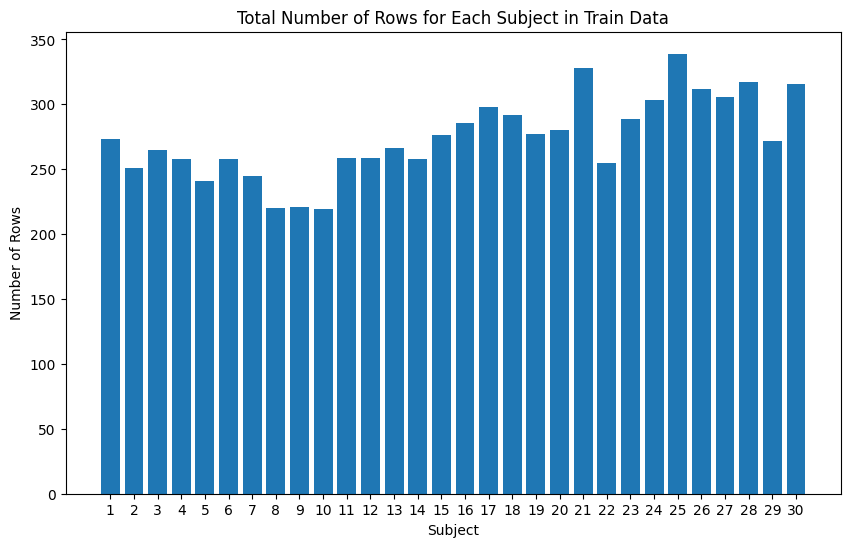

In [ ]:
# Plotting the bar graph
values, counts = np.unique(subject_train['subject'], return_counts=True)
plt.figure(figsize=(10, 6))
plt.bar(values, counts)
plt.xlabel('Subject')
plt.ylabel('Number of Rows')
plt.title('Total Number of Rows for Each Subject in Train Data')
plt.xticks(values)  # Set x-axis ticks to subject numbers
plt.show()

In [ ]:
y_train = subject_train['subject']
X_train = subject_train.drop('subject', axis=1)

y_test = subject_test['subject']
X_test = subject_test.drop('subject', axis=1)

# of the participants range from 0-29, needed for one hot encoding
y_train = y_train - 1
y_test = y_test - 1

# one hot encode y
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
# Assuming you want 5 time steps
time_steps = 1

# Compute the number of samples after adjusting for time steps
train_num_samples = X_train.shape[0] // time_steps
test_num_samples = X_test.shape[0] // time_steps


# Reshape the data to be in 3D (num_samples, time_steps, num_features)
X_train = np.array(X_train).reshape((train_num_samples, time_steps, X_train.shape[1]))
X_test = np.array(X_test).reshape((test_num_samples, time_steps, X_test.shape[1]))

In [ ]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(units = 64, activation='relu'))
model.add(Dense(y_train.shape[1], activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │         353,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 30)                  │           1,950 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 363,998 (1.39 MB)

 Trainable params: 363,998 (1.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_history = model.fit(X_train, y_train, epochs = 60, validation_split = 0.20, batch_size = 1024, verbose = 1)

Epoch 1/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.0395 - loss: 3.4032 - val_accuracy: 0.0522 - val_loss: 3.3718
Epoch 2/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.0597 - loss: 3.3712 - val_accuracy: 0.0801 - val_loss: 3.3427
Epoch 3/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.0733 - loss: 3.3430 - val_accuracy: 0.1019 - val_loss: 3.3005
Epoch 4/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.0970 - loss: 3.2866 - val_accuracy: 0.1177 - val_loss: 3.2253
Epoch 5/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.1140 - loss: 3.2136 - val_accuracy: 0.1493 - val_loss: 3.1400
Epoch 6/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.1416 - loss: 3.1295 - val_accuracy: 0.1966 - val_loss: 3.0183
Epoch 7/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.1748 - loss: 3.0214 - val_accuracy: 0.2269 - val_loss: 2.9127
Epoch 8/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.2054 - loss: 2.9139 - val_accuracy: 0.2494 - val_loss: 2.8012

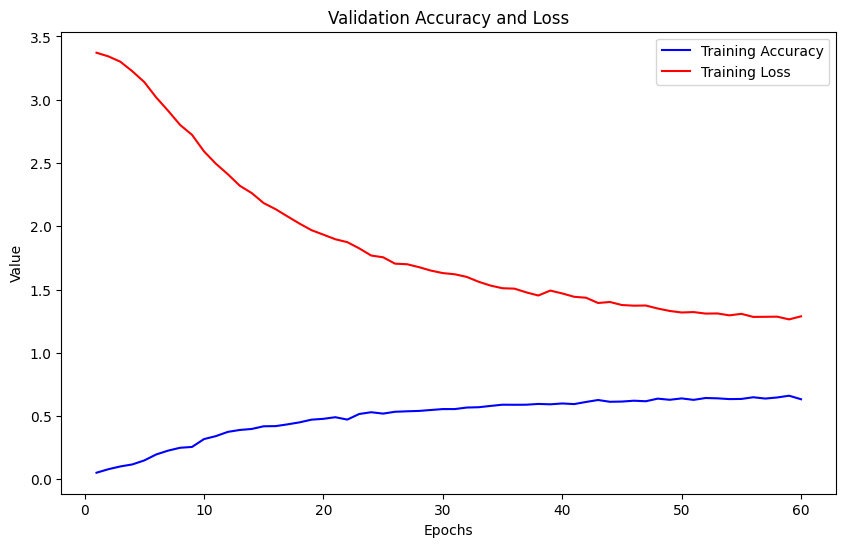

In [ ]:
epochs = range(1, len(model_history.history['accuracy']) + 1)

plt.figure(figsize=(10, 6))

# Accuracy plot
plt.plot(epochs, model_history.history['val_accuracy'], label='Validation Accuracy', color='blue')
plt.plot(epochs, model_history.history['val_loss'], label='Validation Loss', color='red')

plt.title('Validation Accuracy and Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()

# Display the plot
plt.show()

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


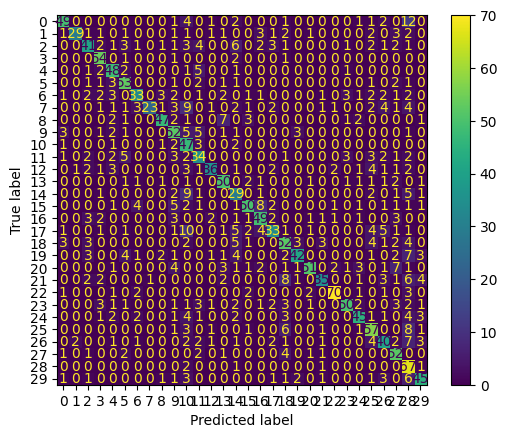

In [ ]:
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=1)
y_test_pred = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_pred, predictions)
cm_disp = ConfusionMatrixDisplay(confusion_matrix= cm)
cm_disp.plot()
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6658 - loss: 1.2195


[1.234931468963623, 0.6616504788398743]

(8239, 1, 562)